# Week 3: Fitting

In many different cases, we might have a model for how a system works, and want to fit that model to a set of observations. 

We're going to investigate a paper using a classic model of multivalent binding to [examine interaction of IgG antibodies with the immune system](https://doi.org/10.1016/j.cels.2018.05.018). Identifying whether and how this model fits has led to a better understanding of how our immune system recognizes diseased cells, and how to design antibodies with optimized responses.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import binom
from scipy.optimize import brentq

np.seterr(over='raise')

def bindingModel(Rtot, Ka, v, L0):
    '''
    Returns the number of mutlivalent ligand bound to a cell with Rtot
    receptors, granted each epitope of the ligand binds to the receptor
    kind in question with association constant Ka and cross-links with
    other receptors with crosslinking constant Kx. All eq derived from
    Stone et al. (2001).

    Note that this function only takes a single condition at once. All
    arguments should be scalars (not vectors)!
    '''
    v = np.int_(v)
    Kx = np.power(10.0, -12.25)
    
    # Mass balance for receptor species, to identify the amount of free receptor
    diffFunAnon = lambda x: Rtot-x*(1+v*L0*(Ka)*(1+Kx*x)**(v-1))
    
    ## Solve Req by calling least_squares
    Req, lsq = brentq(diffFunAnon, 0.0, Rtot, full_output=True)
    if lsq.converged is False:
        print(lsq)
        raise RuntimeError("Failure in solving for Req.")
    
    # Calculate vieq from equation 1
    vieq = L0*Req*binom(v, np.arange(1, v + 1))*np.power(Kx*Req, np.arange(v))*Ka
    return np.sum(vieq)


# L0 for each TNP-BSA
# Define concentrations of TNP-4-BSA and TNP-26-BSA, respectively
tnpbsaL0 = np.array([1/67122,1/70928])*1e-3*5


#### (1) Load the data (`robinett.csv`, from Fig. 1). Decide how to account for the control conditions. Plot the data and explore the relationship you see with affinity and valency (see Fig. 1C/D/E for ideas).

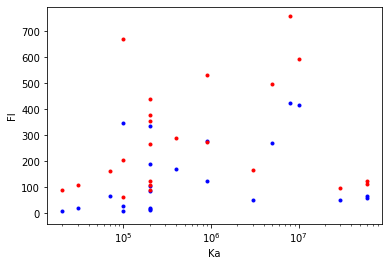

In [2]:
data = np.genfromtxt("robinett.csv", delimiter=",")

lowv = data[1:, 2] - 9.96 # subtract off average of controls
highv = data[1:, 3] - 9.96 # subtract off average of controls
Ka = data[1:, 4]

plt.semilogx(Ka, lowv, 'b.');
plt.semilogx(Ka, highv, 'r.');
plt.xlabel("Ka");
plt.ylabel("FI");

#### (2) To fit the model, we'll first need a function that takes the unknown parameters (Rtot, scaling), uses them to run the model for each condition, scales them to the units of the actual measurements (fluorescence), thus finding the predictions for each condition.

Use the fit parameters shown in Fig. 2 and overlay with the measurements to ensure your function is roughly working. The scaling to fluorescence units for each valency should themselves be unknown parameters.

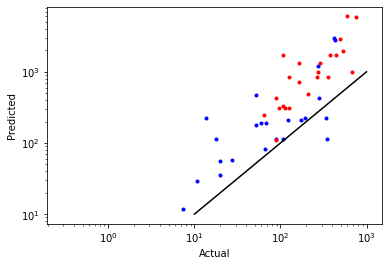

In [11]:
# Rough values for Rtot from the paper
RtotNot = np.array([1e5, 5e5, 1e6, 1e6, 2e6, 2.0e6])
# Rough values for scaling
# The extra 1000.0 was decided by hand
scaleNot = np.power(10.0, [-5.7, -5.5]) * 1000.0

def prediction(RtotIn, scaleIn):
    predictions = np.zeros((lowv.size, 2))

    for ii in range(lowv.size):
        predictions[ii, 0] = bindingModel(RtotIn[ii // 5], Ka[ii], 4, tnpbsaL0[0])
        predictions[ii, 1] = bindingModel(RtotIn[ii // 5], Ka[ii], 26, tnpbsaL0[1])

    predictions[:, 0] *= scaleIn[0]
    predictions[:, 1] *= scaleIn[1]

    return predictions

outt = prediction(RtotNot, scaleNot)

plt.loglog(lowv, outt[:, 0], 'b.');
plt.loglog(highv, outt[:, 1], 'r.');
plt.loglog([10, 1000], [10, 1000], 'k')
plt.xlabel("Actual")
plt.ylabel("Predicted");

#### (3) Now use `scipy.optimize.least_squares` to find the least squares solution.

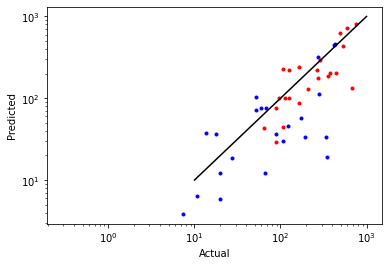

In [93]:
from scipy.optimize import least_squares

def residuals(x, indexx=None):
    predd = prediction(x[:6], x[6:])

    if indexx is None:
        predd[:, 0] = predd[:, 0] - lowv
        predd[:, 1] = predd[:, 1] - highv
    else:
        predd = predd[indexx, :]
        predd[:, 0] = predd[:, 0] - lowv[indexx]
        predd[:, 1] = predd[:, 1] - highv[indexx]

    return predd.flatten()

def fit(indexx=None, retCost=False, fixP=None, fixV=None):
    x0 = np.concatenate((RtotNot, scaleNot))
    bnds = (np.zeros_like(x0), np.full_like(x0, np.inf))

    if fixP is not None:
        x0[fixP] = fixV
        lbnd = np.zeros_like(x0)
        lbnd[fixP] = fixV*0.999
        ubnd = np.full_like(x0, np.inf)
        ubnd[fixP] = fixV*1.001
        bnds = (lbnd, ubnd)

    result = least_squares(residuals, x0, bounds=bnds, args=(indexx, ), jac="3-point")
    if retCost:
        return result.cost
    return result.x

x = fit()
outt = predd = prediction(x[:6], x[6:])

plt.loglog(lowv, outt[:, 0], 'b.');
plt.loglog(highv, outt[:, 1], 'r.');
plt.loglog([10, 1000], [10, 1000], 'k')
plt.xlabel("Actual")
plt.ylabel("Predicted");

#### (4) Using leave-one-out crossvalidation, does this model predict the data? Plot the measured vs. predicted data.

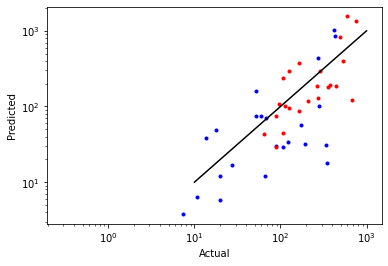

In [94]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

vcpred = np.zeros((lowv.size, 2))

for train_index, test_index in loo.split(vcpred):
    xcv = fit(train_index)
    predd = prediction(xcv[:6], xcv[6:])
    vcpred[test_index, :] = predd[test_index, :]

plt.loglog(lowv, vcpred[:, 0], 'b.');
plt.loglog(highv, vcpred[:, 1], 'r.');
plt.loglog([10, 1000], [10, 1000], 'k')
plt.xlabel("Actual")
plt.ylabel("Predicted");


#### (5) Using bootstrap estimation, plot the confidence interval of the model predictions along with the data points.
"Confidence interval" does not have a precise definition. For example, you could show the interval over which 50% of the bootstrap samples fall (25th to 75th quantile).

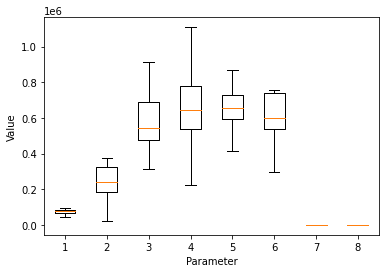

In [95]:
from sklearn.utils import resample

xresamp = np.zeros((50, 8))

for ii in range(xresamp.shape[0]):
    idxr = resample(np.arange(lowv.size))
    xresamp[ii, :] = fit(idxr)

plt.boxplot(xresamp, showfliers=False);
plt.xlabel("Parameter")
plt.ylabel("Value");

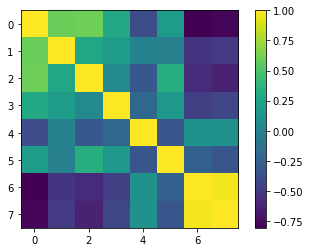

In [96]:
# There's strong correlation between the parameters in the bootstrap samples.
# This is a good indication that the parameters can compensate for one another,
# which we will see in the last question.

plt.imshow(np.corrcoef(xresamp.T));
plt.colorbar();

#### (6) You may find that a subset of points are predicted more poorly than the others. Which are those? What could be wrong about these data points leading to the poor prediction, assuming that the model and binding measurements are true and accurate?

Some points can simply be predicted more poorly due to error. Additionally, the model is dependent on accurate affinity estimates. If any of the input affinities are off, that could lead to outlier points.

#### (7) Now, we will perform a local sensitivity analysis to look at the dependence of the model results on each parameter. Vary each parameter up and down by 10-fold **while holding the others constant**, and plot the sum of squared error. Which parameter influences the fit the most? Which one the least?

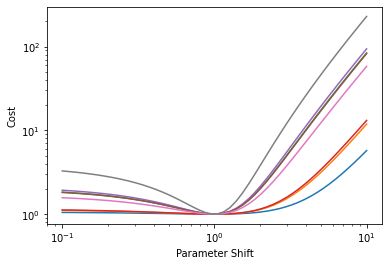

In [97]:
xOpt = fit()
rangee = np.logspace(-1.0, 1.0, base=10.0)

costt = np.zeros((xOpt.size, rangee.size))

for ii in range(xOpt.size):
    for jj in range(rangee.size):
        xCur = xOpt.copy()
        xCur[ii] *= rangee[jj]
        costt[ii, jj] = np.linalg.norm(residuals(xCur))**2.0

costt = costt.T / np.min(costt)

plt.loglog(rangee, costt);
plt.xlabel("Parameter Shift");
plt.ylabel("Cost");

#### (8) While easier to perform, a local sensitivity analysis ignores codependency between the parameters. Do you anticipate your predictions of the parameter values will be more or less specified with a global analysis?

Less specified because other variables will be able to compensate for the change in this one parameter.

#### (9) Now, vary each parameter from the optimal solution, *allowing the other parameters to vary*. Was your prediction true? How are the other parameters varying when the scaling factor increases?

Hint: The easiest way to do this is mess with the bounds of the least squares solver.

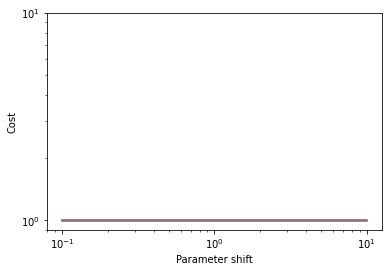

In [99]:
xOpt = fit()
rangee = np.logspace(-1.0, 1.0, 3, base=10.0)

costt = np.zeros((xOpt.size, rangee.size))

for ii in range(xOpt.size):
    for jj in range(rangee.size):
        costt[ii, jj] = fit(fixP=ii, fixV=xOpt[ii]*rangee[jj], retCost=True)

costt = costt.T / np.min(costt)

plt.loglog(rangee, costt);
plt.ylim(0.9, 10.0); # Provide roughly the same scale as above.
plt.ylabel("Cost")
plt.xlabel("Parameter shift");

The parameters are completely unconstrained by the data once we allow them to compensate for one another.